In [665]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or 'retina'
%matplotlib inline
# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler


sns.set(context='notebook', style='whitegrid')

In [719]:
df = pd.read_csv('/Users/aseo/Downloads/WineMag130K.csv')

In [720]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [721]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [722]:
df.drop('Unnamed: 0', axis=1, inplace = True)

In [723]:
df.drop('taster_twitter_handle', axis=1, inplace = True)

In [724]:
df['Vintage'] = df.title.str.extract(r'(\d+[.\d]*)')

In [725]:
df.drop('region_2', axis=1, inplace = True)

In [726]:
df.dropna(inplace=True)

In [727]:
df.drop('designation', axis=1, inplace = True)

In [728]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51690 entries, 3 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      51690 non-null  object 
 1   description  51690 non-null  object 
 2   points       51690 non-null  int64  
 3   price        51690 non-null  float64
 4   province     51690 non-null  object 
 5   region_1     51690 non-null  object 
 6   taster_name  51690 non-null  object 
 7   title        51690 non-null  object 
 8   variety      51690 non-null  object 
 9   winery       51690 non-null  object 
 10  Vintage      51690 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.7+ MB


In [729]:
df = df[['taster_name', 'description','title',
         'variety', 'Vintage', 'winery',
         'country', 'province', 
         'region_1', 'price', 'points'
         ]]

In [730]:
df = df.rename(columns={'taster_name': 'Taster', 
                        'description': 'Description', 
                        'title': 'Title',
                        'variety': 'Varietal',
                        'winery': 'Winery',
                        'country': 'Country',
                        'province': 'Province',
                        'region_1': 'Region',
                        'price': 'Price',
                        'points': 'Score'
                       })

In [731]:
df.head()

,Taster,Description,Title,Varietal,Vintage,Winery,Country,Province,Region,Price,Score
3,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ...",St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,2013,St. Julian,US,Michigan,Lake Michigan Shore,13.0,87
4,Paul Gregutt,"Much like the regular bottling from 2012, this...",Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,2012,Sweet Cheeks,US,Oregon,Willamette Valley,65.0,87
5,Michael Schachner,Blackberry and raspberry aromas show a typical...,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,2011,Tandem,Spain,Northern Spain,Navarra,15.0,87
6,Kerin O’Keefe,"Here's a bright, informal red that opens with ...",Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,2013,Terre di Giurfo,Italy,Sicily & Sardinia,Vittoria,16.0,87
9,Roger Voss,This has great depth of flavor with its fresh ...,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,2012,Jean-Baptiste Adam,France,Alsace,Alsace,27.0,87


### Two versions of Data

One where columns are grouped max to 11 (top 10 plus Other) to facilitate dummy variables

In [733]:
df_dummies = df.copy()

#### Grouping Categorical Columns

In [734]:
df_dummies['Province'].value_counts().head(11)

California          13773
Washington           5790
Oregon               3731
Northern Spain       3000
Mendoza Province     2388
Burgundy             2094
Tuscany              2017
New York             1741
Piedmont             1617
Alsace               1533
Loire Valley         1233
Name: Province, dtype: int64

In [735]:
conditions = [
    (df['Province'] == 'California'),
    (df['Province'] == 'Washington'),
    (df['Province'] == 'Oregon'),
    (df['Province'] == 'Northern Spain'),
    (df['Province'] == 'Mendoza Province')]

choices = ['California', 'Washington', 'Oregon','Northern Spain',
          'Mendoza Province']
df_dummies['Province'] = np.select(conditions, choices, default='Other')

In [736]:
df_dummies['Province'].value_counts().head(11)

Other               23008
California          13773
Washington           5790
Oregon               3731
Northern Spain       3000
Mendoza Province     2388
Name: Province, dtype: int64

In [737]:
df_dummies['Country'].value_counts()

US           25486
France       10313
Italy         6777
Spain         4760
Argentina     2781
Australia     1399
Canada         174
Name: Country, dtype: int64

In [738]:
conditions = [
    (df['Country'] == 'US'),
    (df['Country'] == 'France'),
    (df['Country'] == 'Italy'),
    (df['Country'] == 'Spain'),
    (df['Country'] == 'Argentina')]
choices = ['US', 'France', 'Italy','Spain','Argentina']
df_dummies['Country'] = np.select(conditions, choices, default='Other')

In [739]:
df_dummies['Country'].value_counts()

US           25486
France       10313
Italy         6777
Spain         4760
Argentina     2781
Other         1573
Name: Country, dtype: int64

In [740]:
df_dummies['Region'].value_counts().head(10)

Columbia Valley (WA)    2451
Mendoza                 1626
Willamette Valley       1606
Alsace                  1488
Russian River Valley    1293
Rioja                   1282
Napa Valley             1144
Finger Lakes            1028
Paso Robles              921
Barolo                   853
Name: Region, dtype: int64

In [741]:
conditions = [
    (df['Region'] == 'Columbia Valley (WA)'),
    (df['Region'] == 'Mendoza'),
    (df['Region'] == 'Willamette Valley'),
    (df['Region'] == 'Alsace'),
    (df['Region'] == 'Russian River Valley')]

choices = ['Columbia Valley (WA)', 'Mendoza', 'Willamette Valley','Alsace',
          'Russian River Valley']
df_dummies['Region'] = np.select(conditions, choices, default='Other')

In [742]:
df_dummies['Region'].value_counts().head(20)

Other                   43226
Columbia Valley (WA)     2451
Mendoza                  1626
Willamette Valley        1606
Alsace                   1488
Russian River Valley     1293
Name: Region, dtype: int64

In [743]:
df['Varietal'].value_counts().head(10)

Pinot Noir                  6618
Chardonnay                  4732
Red Blend                   4677
Cabernet Sauvignon          3111
Bordeaux-style Red Blend    2219
Syrah                       1982
Riesling                    1848
Rosé                        1773
Malbec                      1766
Sauvignon Blanc             1391
Name: Varietal, dtype: int64

In [744]:
conditions = [
    (df['Varietal'] == 'Pinot Noir'),
    (df['Varietal'] == 'Chardonnay'),
    (df['Varietal'] == 'Red Blend'),
    (df['Varietal'] == 'Cabernet Sauvignon'),
    (df['Varietal'] == 'Bordeaux-style Red Blend')]

choices = ['Pinot Noir', 'Chardonnay', 'Red Blend',
           'Cabernet Sauvignon', 'Bordeaux-style Red Blend']

df_dummies['Varietal'] = np.select(conditions, choices, default='Other')

In [745]:
df_dummies['Varietal'].value_counts().head(20)

Other                       30333
Pinot Noir                   6618
Chardonnay                   4732
Red Blend                    4677
Cabernet Sauvignon           3111
Bordeaux-style Red Blend     2219
Name: Varietal, dtype: int64

In [746]:
df['Winery'].value_counts().head()

Columbia Crest           157
Chateau Ste. Michelle    133
Trapiche                 108
Georges Duboeuf          107
Testarossa               101
Name: Winery, dtype: int64

In [747]:
#df_dummies.drop('Winery', axis=1, inplace = True)

In [748]:
conditions = [
    (df['Winery'] == 'Columbia Crest'),
    (df['Winery'] == 'Chateau Ste. Michelle'),
    (df['Winery'] == 'Trapiche'), 
    (df['Winery'] == 'Georges Duboeuf'),
    (df['Winery'] == 'Testarossa'),
    (df['Winery'] == 'Chehalem'), 
    (df['Winery'] == "D'Arenberg"), 
    (df['Winery'] == 'Naggiar'),     
    (df['Winery'] == 'Louis Latour'),
    (df['Winery'] == 'Georges Vigouroux')]

choices = ['Columbia Crest', 'Chateau Ste. Michelle', 'Trapiche',
           'Georges Duboeuf', 'Testarossa', 'Chehalem', 
           "D'Arenberg", 'Naggiar', 'Louis Latour', 'Georges Vigouroux']
          
df_dummies['Winery'] = np.select(conditions, choices, default='Other')

In [749]:
df_dummies['Winery'].value_counts().head(20)

Other                    50614
Columbia Crest             157
Chateau Ste. Michelle      133
Trapiche                   108
Georges Duboeuf            107
Testarossa                 101
Chehalem                   100
D'Arenberg                  96
Naggiar                     92
Louis Latour                91
Georges Vigouroux           91
Name: Winery, dtype: int64

In [750]:
df_dummies = pd.get_dummies(df_dummies, columns=['Province', 'Country', 'Region', 'Varietal', 'Winery'], drop_first=True)
#getting dummies for new categorical columns

In [751]:
df_dummies['Scores'] = df_dummies['Score']
df_dummies.drop('Score', axis=1, inplace = True)

In [752]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51690 entries, 3 to 129970
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Taster                       51690 non-null  object 
 1   Description                  51690 non-null  object 
 2   Title                        51690 non-null  object 
 3   Vintage                      51690 non-null  object 
 4   Price                        51690 non-null  float64
 5   Province_Mendoza Province    51690 non-null  uint8  
 6   Province_Northern Spain      51690 non-null  uint8  
 7   Province_Oregon              51690 non-null  uint8  
 8   Province_Other               51690 non-null  uint8  
 9   Province_Washington          51690 non-null  uint8  
 10  Country_France               51690 non-null  uint8  
 11  Country_Italy                51690 non-null  uint8  
 12  Country_Other                51690 non-null  uint8  
 13  Country_Spain  

In [753]:
df_dummies = df_dummies.rename(columns={'Scores': 'Score'})

In [776]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51690 entries, 3 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Taster       51690 non-null  object 
 1   Description  51690 non-null  object 
 2   Title        51690 non-null  object 
 3   Varietal     51690 non-null  object 
 4   Vintage      51690 non-null  object 
 5   Winery       51690 non-null  object 
 6   Country      51690 non-null  object 
 7   Province     51690 non-null  object 
 8   Region       51690 non-null  object 
 9   Price        51690 non-null  float64
 10  Score        51690 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 4.7+ MB


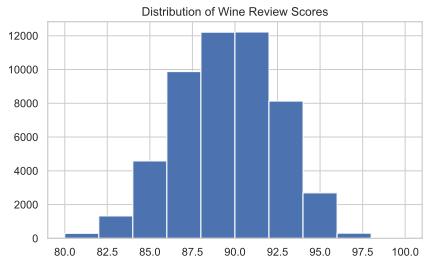

In [777]:
df.hist('Score')
plt.title('Distribution of Wine Review Scores');

In [778]:
df.Score.mean()

89.01553491971367

In [779]:
df.Score.median()

89.0

In [780]:
df['Quality'] = df['Score'].apply(lambda x: 'Bad' if x<df.Score.median() else 'Good')
#assigning any wines with less than median score as 
#"Bad" or 0 and above as good

In [781]:
df_dummies['Quality'] = df_dummies['Score'].apply(lambda x: 'Bad' if x<df_dummies.Score.median() else 'Good')
#same assignment to dummy variabled df

In [782]:
df['Quality'].value_counts()

Good    28736
Bad     22954
Name: Quality, dtype: int64

### Setting X and y for dummy version of data

In [783]:
df_dummies.iloc[:,3:-2]

,Vintage,Price,Province_Mendoza Province,Province_Northern Spain,Province_Oregon,Province_Other,Province_Washington,Country_France,Country_Italy,Country_Other,...,Winery_Chehalem,Winery_Columbia Crest,Winery_D'Arenberg,Winery_Georges Duboeuf,Winery_Georges Vigouroux,Winery_Louis Latour,Winery_Naggiar,Winery_Other,Winery_Testarossa,Winery_Trapiche
3,2013,13.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2012,65.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,2011,15.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,2013,16.0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9,2012,27.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,2010,57.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
129962,2012,40.0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
129965,2013,28.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
129968,2013,30.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [784]:
X_dum = df_dummies.iloc[:,3:-2]
y_dum = df_dummies['Quality']

In [785]:
print(X_dum.shape)
print(y_dum.shape)

(51690, 32)
(51690,)


## KNN

Dummy variable of data must be used

In [712]:
X_rest, X_test, y_rest, y_test = train_test_split(X_dum, y_dum, test_size = .2, random_state=42)
#hold out 20% for final testing
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size = .25, random_state=42)
#60% train, 20% val

In [713]:
y_train = y_train.map({'Good': 1, 'Bad': 0}).astype(int)
y_val = y_val.map({'Good': 1, 'Bad': 0}).astype(int)
y_test = y_test.map({'Good': 1, 'Bad': 0}).astype(int)

In [714]:
y_rest = y_rest.map({'Good': 1, 'Bad': 0}).astype(int)

### Evaluation procedure #1: Train/test split

In [715]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(31014, 32)
(10338, 32)
(10338, 32)
(31014,)
(10338,)
(10338,)


In [552]:
# Train on training set, and Score on training set and validation set
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
y_pred_val = knn.predict(X_val)

print("Initial training set precision: ", metrics.precision_score(y_train, knn.predict(X_train)))
print("Initial validation set precision: ", metrics.precision_score(y_val, knn.predict(X_val)))

#0.782 vs 0.724 training set overfitting

Initial training set precision:  0.7816079415293989
Initial validation set precision:  0.7240518962075848


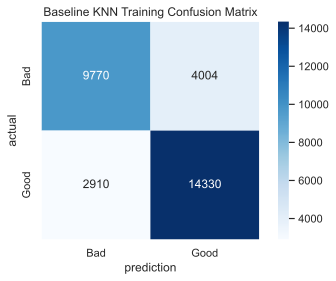

In [553]:
knn_confusion_train_base = confusion_matrix(y_train, knn.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(knn_confusion_train_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline KNN Training Confusion Matrix');

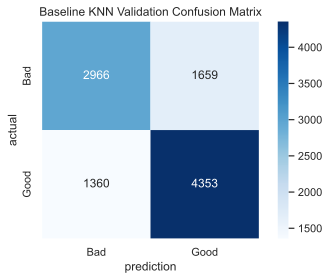

In [554]:
knn_confusion_val_base = confusion_matrix(y_val, knn.predict(X_val))
plt.figure(dpi=80)
sns.heatmap(knn_confusion_val_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline KNN Validation Confusion Matrix');

### Evaluation procedure #2: Cross Validation

In [381]:
#5-fold cross-validation with K=5 for KNN
knn = KNeighborsClassifier(n_neighbors=5)

precisions = cross_val_score(knn, X_rest, y_rest, cv=5, scoring='precision')

print(precisions)
print(precisions.mean())

[0.73580297 0.72876088 0.72549428 0.73047035 0.71950464]
0.7280066237376437


In [383]:
# search for an optimal value of K for KNN
k_range = list(range(1, 51))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    precisions = cross_val_score(knn, X_rest, y_rest, cv=5, scoring='precision')
    k_scores.append(precisions.mean())

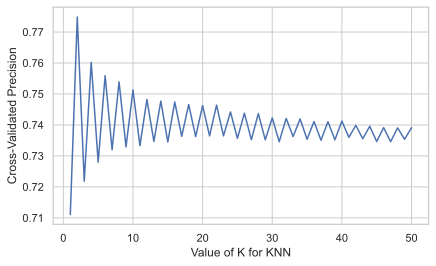

In [384]:
# plot the value of K for KNN (x-axis) versus the cross-validated precision (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Precision');

#k=2 best results 

### Retrain Model for K=2

In [555]:
# Train on training set, and Score on training set and validation set
knn2 = KNeighborsClassifier(n_neighbors=2)

knn2.fit(X_train, y_train)
#y_pred = knn2.predict(X_train)
#y_pred_val = knn2.predict(X_val)

print("Tuned training set precision: ", metrics.precision_score(y_train, knn2.predict(X_train)))
print("Tuned validation set precision: ", metrics.precision_score(y_val, knn2.predict(X_val)))

#Initial Results: 0.782 vs 0.724 training set overfitting
#Tuned Results: 0.892 vs 0.770 - training, validation both improved

Tuned training set precision:  0.8920940170940171
Tuned validation set precision:  0.7702668994761785


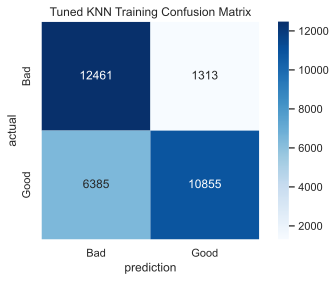

In [556]:
knn_confusion_train_tuned = confusion_matrix(y_train, knn2.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(knn_confusion_train_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned KNN Training Confusion Matrix');

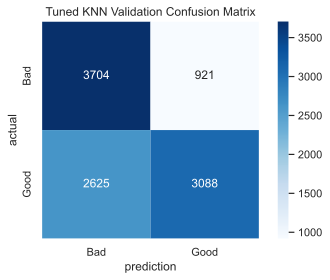

In [557]:
knn_confusion_val_tuned = confusion_matrix(y_val, knn2.predict(X_val))
plt.figure(dpi=80)
sns.heatmap(knn_confusion_val_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned KNN Validation Confusion Matrix');

## Logistic Regression

Have to use dummy variable version of dataset again

### Evaluation procedure #1: Train/test split

In [388]:
# X_rest, X_test, y_rest, y_test = train_test_split(X_dum, y_dum, test_size = .2, random_state=42)
# #hold out 20% for final testing
# X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size = .25, random_state=42)
# #60% train, 20% val

In [389]:
# y_train = y_train.map({'Good': 1, 'Bad': 0}).astype(int)
# y_val = y_val.map({'Good': 1, 'Bad': 0}).astype(int)
# y_test = y_test.map({'Good': 1, 'Bad': 0}).astype(int)

In [786]:
lm = LogisticRegression()
lm.fit(X_train, y_train)
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = lm.predict(X_train)
y_predict_val = lm.predict(X_val)
print("Initial precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#initial Precision of 0.755 on train
print("Initial precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
#initial Precision of 0.752 on val

#focus is on precision but don't want to sacrifice recall too much
#so keeping track
print("")
print("Initial recall on train: {:6.3f}".format(recall_score(y_train, y_predict)))
#initial Recall of 0.719 on train
print("Initial recall on validation: {:6.3f}".format(recall_score(y_val, y_predict_val)))
#initial Recall of 0.718 on val

Initial precision on train:  0.755
Initial precision on validation:  0.752

Initial recall on train:  0.719
Initial recall on validation:  0.718


In [800]:
print("Initial accuracy on validation: {:6.3f}".format(accuracy_score(y_val, y_predict_val)))

Initial accuracy on validation:  0.713


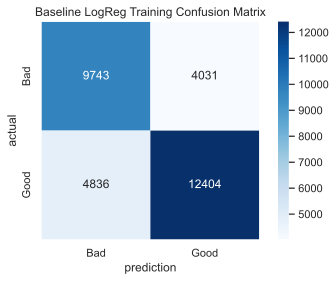

In [787]:
lm_confusion_train_base = confusion_matrix(y_train, lm.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(lm_confusion_train_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline LogReg Training Confusion Matrix');

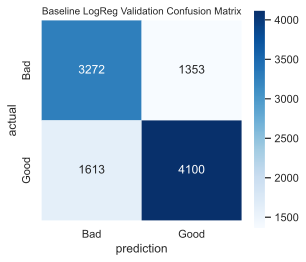

In [799]:
lm_confusion_val_base = confusion_matrix(y_val, lm.predict(X_val))
plt.figure(figsize=(4,4), dpi=80)
sns.heatmap(lm_confusion_val_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline LogReg Validation Confusion Matrix', fontdict = {'fontsize' : 10});

In [561]:
lm.coef_

array([[-0.00061546,  0.05118872, -0.07090483, -0.088366  ,  0.0277405 ,
        -0.19817771,  0.06460793,  0.12514771, -0.12664253,  0.03740261,
        -0.15481296,  0.15881497,  0.03083691, -0.05736369, -0.2047089 ,
         0.03986623,  0.01804808, -0.10120662,  0.03571389,  0.04692065,
         0.0616475 , -0.08045185,  0.0028023 , -0.001017  ,  0.00585409,
        -0.00298744,  0.00101707, -0.00044743, -0.00395999, -0.0704849 ,
         0.00279181, -0.00121081]])

In [562]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lm.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

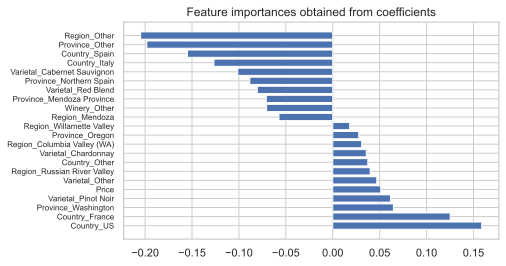

In [563]:
mask = abs(importances['Importance']) > 0.01

importances2 = importances[mask]

plt.barh(y=importances2['Attribute'], width=importances2['Importance'])
plt.title('Feature importances obtained from coefficients', size=12)
plt.yticks(size=8)
plt.show()

#plotting feature importance

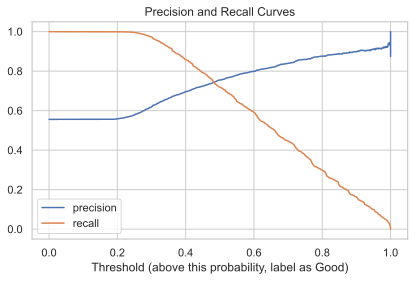

In [564]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, lm.predict_proba(X_train)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Good)');
plt.title('Precision and Recall Curves');

### Adjusting Threshold (Risk of False Negatives Low)

In [631]:
y_predict = lm.predict_proba(X_train)[:,1] > 0.7
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
print("Tuned recall on train: {:6.3f}".format(recall_score(y_train, y_predict)))
#Precision went from 0.755 to 0.840
#Recall went from 0.719 to 0.446

Tuned precision on train:  0.840
Tuned recall on train:  0.446


In [630]:
y_predict_val = lm.predict_proba(X_val)[:,1] > 0.7
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
print("Tuned recall on validation: {:6.3f}".format(recall_score(y_val, y_predict_val)))

#Precision went from 0.752 to 0.840
#Recall went from 0.718 to 0.439

#precision: tuned is 0.840 and 0.840 for train and val respectively
#recall: tuned is 0.446 and 0.439 for train and val respectively

Tuned precision on validation:  0.840
Tuned recall on validation:  0.439


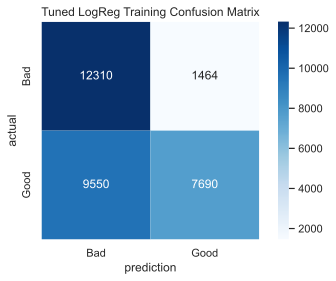

In [657]:
lm_confusion_train_tuned = confusion_matrix(y_train, lm.predict_proba(X_train)[:,1] > 0.7)
plt.figure(dpi=80)
sns.heatmap(lm_confusion_train_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned LogReg Training Confusion Matrix');

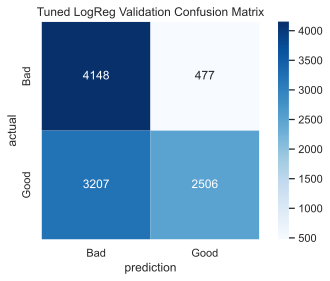

In [658]:
lm_confusion_val_tuned = confusion_matrix(y_val, lm.predict_proba(X_val)[:,1] > 0.7)
plt.figure(dpi=80)
sns.heatmap(lm_confusion_val_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned LogReg Validation Confusion Matrix');

### Evaluation procedure #2: Cross Validation

In [411]:
#5-fold cross-validation with K=5 for KNN
lr = LogisticRegression()

precisions = cross_val_score(lr, X_rest, y_rest, cv=5, scoring='precision')

print(precisions)
print(precisions.mean())

#[0.74742563 0.75657143 0.75656393 0.75691372 0.76840011]
#mean = 0.7571749630571001

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[0.74742563 0.75657143 0.75656393 0.75691372 0.76840011]
0.7571749630571001


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [413]:
# search for an optimal value of C for LogReg
c_range = list(range(1, 100))
c_scores = []

for c in c_range:
    lr = LogisticRegression(C = c)
    precisions = cross_val_score(lr, X_rest, y_rest, cv=5, scoring='precision')
    c_scores.append(precisions.mean())

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

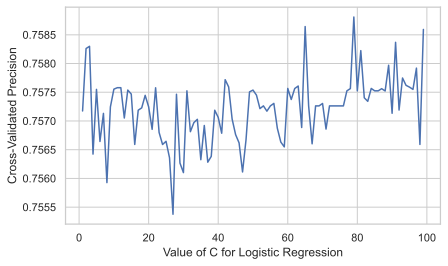

In [414]:
# plot the value of C for LogReg (x-axis) versus the cross-validated precision (y-axis)
plt.plot(c_range, c_scores)
plt.xlabel('Value of C for Logistic Regression')
plt.ylabel('Cross-Validated Precision');

#value of C has minimal impact, leave as is
#threshold adjustment sufficient

## Decision Tree

### Evaluation procedure #1: Baseline

In [537]:
from sklearn.tree import DecisionTreeClassifier

In [569]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_predict = dt.predict(X_train)
y_predict_val = dt.predict(X_val)
print("Initial precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#initial Precision of 0.864 on train
print("Initial precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
#initial Precision of 0.740 on val
#overfitting

Initial precision on train:  0.864
Initial precision on validation:  0.740


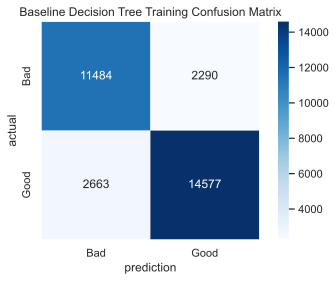

In [570]:
dt_confusion_train_base = confusion_matrix(y_train, dt.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(dt_confusion_train_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline Decision Tree Training Confusion Matrix');

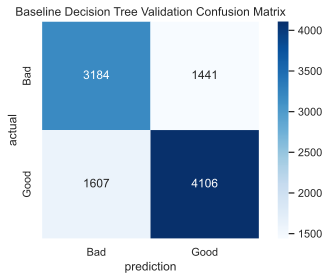

In [571]:
dt_confusion_val_base = confusion_matrix(y_val, dt.predict(X_val))
plt.figure(dpi=80)
sns.heatmap(dt_confusion_val_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline Decision Tree Validation Confusion Matrix');

### Evaluation procedure #2: GridSearchCV

In [572]:
param_grid = {
    'max_depth': [2,4,6,8,10,12,14,16,18,20],
    'random_state': [42]
}

In [573]:
dt = DecisionTreeClassifier()

In [574]:
dt_grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 5, scoring = 'precision')

In [575]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                         'random_state': [42]},
             scoring='precision')

In [576]:
print("Best params: ", dt_grid_search.best_params_)
print("")
print("Best estimator: ", dt_grid_search.best_estimator_)
print("")
print("Best score: ", dt_grid_search.best_score_)

Best params:  {'max_depth': 6, 'random_state': 42}

Best estimator:  DecisionTreeClassifier(max_depth=6, random_state=42)

Best score:  0.7500890201359847


In [577]:
y_predict = dt_grid_search.predict(X_train)
y_predict_val = dt_grid_search.predict(X_val)
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))

#train: 0.877 to 0.762
#validation: 0.720 to 0.759
#improvement

Tuned precision on train:  0.762
Tuned precision on validation:  0.759


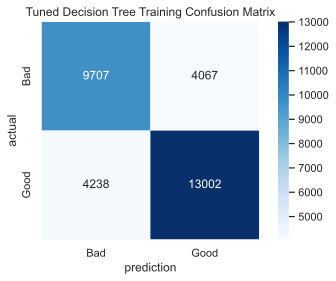

In [578]:
dt_confusion_train_tuned = confusion_matrix(y_train, dt_grid_search.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(dt_confusion_train_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned Decision Tree Training Confusion Matrix');

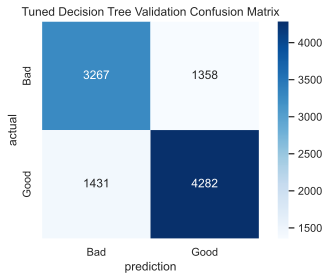

In [579]:
dt_confusion_val_tuned = confusion_matrix(y_val, dt_grid_search.predict(X_val))
plt.figure(dpi=80)
sns.heatmap(dt_confusion_val_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned Decision Tree Validation Confusion Matrix');

## Random Forest

### Evaluation procedure #1: Baseline

In [476]:
from sklearn.ensemble import RandomForestClassifier

In [495]:
# X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size = .2, random_state=42)
# #hold out 20% for final testing
# X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size = .25, random_state=42)
# #60% train, 20% val

In [496]:
# # y_train = y_train.map({'Good': 1, 'Bad': 0}).astype(int)
# y_val = y_val.map({'Good': 1, 'Bad': 0}).astype(int)
# y_test = y_test.map({'Good': 1, 'Bad': 0}).astype(int)

In [497]:
# y_rest = y_rest.map({'Good': 1, 'Bad': 0}).astype(int)

In [580]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_predict = randomforest.predict(X_train)
y_predict_val = randomforest.predict(X_val)
print("Initial precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#initial Precision of 0.842 on train
print("Initial precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
#initial Precision of 0.736 on val
#overfitting

Initial precision on train:  0.842
Initial precision on validation:  0.736


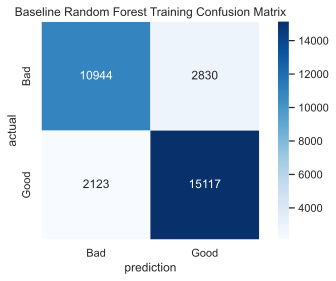

In [581]:
rf_confusion_train_base = confusion_matrix(y_train, randomforest.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(rf_confusion_train_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline Random Forest Training Confusion Matrix');

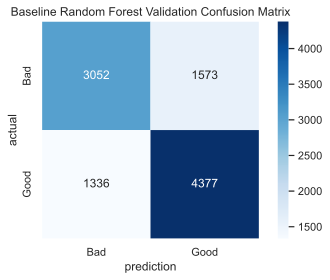

In [582]:
rf_confusion_val_base = confusion_matrix(y_val, randomforest.predict(X_val))
plt.figure(dpi=80)
sns.heatmap(rf_confusion_val_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Baseline Random Forest Validation Confusion Matrix');

### Evaluation procedure #2: GridSearchCV

In [464]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [2,4,6,8,10],
    'max_features': [1,2,3,4,5,6,7],
    'n_estimators': [100, 200, 300, 1000],
    'random_state': [42]
}

In [465]:
rf = RandomForestClassifier()

In [466]:
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, scoring = 'precision')

In [467]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 200, 300, 1000],
                         'random_state': [42]},
             scoring='precision')

In [468]:
print("Best params: ", rf_grid_search.best_params_)
print("")
print("Best estimator: ", rf_grid_search.best_estimator_)
print("")
print("Best score: ", rf_grid_search.best_score_)

Best params:  {'bootstrap': True, 'max_depth': 10, 'max_features': 7, 'n_estimators': 300, 'random_state': 42}

Best estimator:  RandomForestClassifier(max_depth=10, max_features=7, n_estimators=300,
                       random_state=42)

Best score:  0.7473348976658835


In [470]:
y_predict = rf_grid_search.predict(X_train)
y_predict_val = rf_grid_search.predict(X_val)
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))

print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))

Tuned precision on train:  0.765
Tuned precision on validation:  0.732


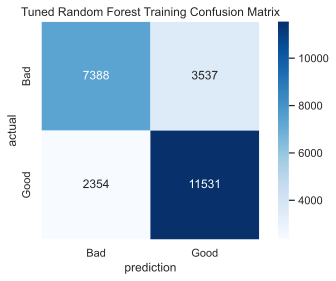

In [473]:
rf_confusion_train_tuned = confusion_matrix(y_train, rf_grid_search.predict(X_train))
plt.figure(dpi=80)
sns.heatmap(rf_confusion_train_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned Random Forest Training Confusion Matrix');

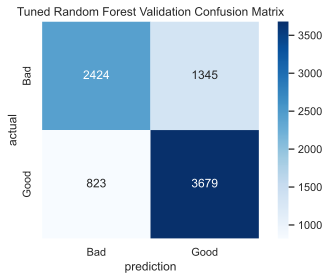

In [474]:
rf_confusion_val_tuned = confusion_matrix(y_val, rf_grid_search.predict(X_val))
plt.figure(dpi=80)
sns.heatmap(rf_confusion_val_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Tuned Random Forest Validation Confusion Matrix');

### Retrain Model for Grid Search Parameters

In [583]:
rf_tuned = RandomForestClassifier(bootstrap = True, 
                                  max_depth = 10, 
                                  max_features = 7, 
                                  n_estimators = 300, 
                                  random_state = 42)
rf_tuned.fit(X_train, y_train)
y_predict = rf_tuned.predict(X_train)
y_predict_val = rf_tuned.predict(X_val)
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#initial Precision of 0.842 on train
#Decreased from 0.842 to 0.762
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
#initial Precision of 0.736 on val
#improved from 0.736 to 0.748

Tuned precision on train:  0.762
Tuned precision on validation:  0.748


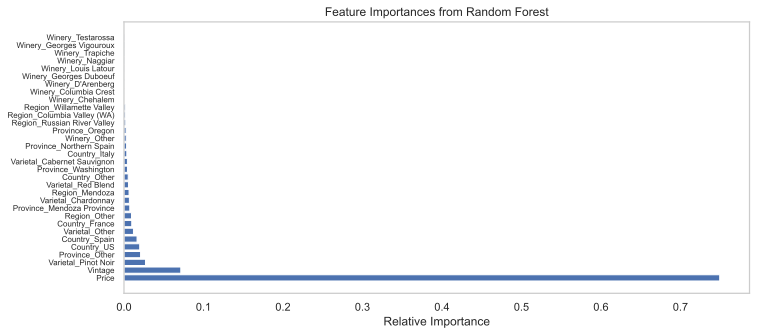

In [599]:
rf_importance = pd.DataFrame(list(zip(X_train.columns,rf_tuned.feature_importances_)))
rf_importance = rf_importance.sort_values(by=1, ascending=False)
plt.figure(figsize=(10,5))
plt.barh(y=rf_importance[0], width=rf_importance[1])
plt.yticks(size=8)
plt.title("Feature Importances from Random Forest")
plt.xlabel('Relative Importance')
plt.grid(b=None)
plt.savefig("Random Forest Feature Importance", bbox_inches = "tight");
plt.show()

## Final Results - Picking a Model(s)

### KNN

In [624]:
# Train on training set, and Score on training set and validation set
knn2 = KNeighborsClassifier(n_neighbors=2)

knn2.fit(X_train, y_train)
#y_pred = knn2.predict(X_train)
#y_pred_val = knn2.predict(X_val)

print("Tuned training set precision: ", metrics.precision_score(y_train, knn2.predict(X_train)))
print("Tuned validation set precision: ", metrics.precision_score(y_val, knn2.predict(X_val)))

#Initial Results: 0.782 vs 0.724 training set overfitting
#Tuned Results: 0.892 vs 0.770 - training, validation both improved

Tuned training set precision:  0.8920940170940171
Tuned validation set precision:  0.7702668994761785


### Logistic Regression

In [ ]:
y_predict = lm.predict_proba(X_train)[:,1] > 0.7
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
print("Tuned recall on train: {:6.3f}".format(recall_score(y_train, y_predict)))
#Precision went from 0.755 to 0.840
#Recall went from 0.719 to 0.446

In [ ]:
y_predict_val = lm.predict_proba(X_val)[:,1] > 0.7
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
print("Tuned recall on validation: {:6.3f}".format(recall_score(y_val, y_predict_val)))

#Precision went from 0.752 to 0.840
#Recall went from 0.718 to 0.439

#precision: tuned is 0.840 and 0.840 for train and val respectively
#recall: tuned is 0.446 and 0.439 for train and val respectively

### Decision Tree

In [ ]:
y_predict = dt_grid_search.predict(X_train)
y_predict_val = dt_grid_search.predict(X_val)
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))

#train: 0.877 to 0.762
#validation: 0.720 to 0.759
#improvement

### Random Forest

In [ ]:
rf_tuned = RandomForestClassifier(bootstrap = True, 
                                  max_depth = 10, 
                                  max_features = 7, 
                                  n_estimators = 300, 
                                  random_state = 42)
rf_tuned.fit(X_train, y_train)
y_predict = rf_tuned.predict(X_train)
y_predict_val = rf_tuned.predict(X_val)
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#initial Precision of 0.842 on train
#Decreased from 0.842 to 0.762
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
#initial Precision of 0.736 on val
#improved from 0.736 to 0.748

### Logistic Regression - Test Set

In [649]:
lm = LogisticRegression()
lm.fit(X_train, y_train)
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = lm.predict(X_train)
y_predict_val = lm.predict(X_val)
print("Initial precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#initial Precision of 0.755 on train
print("Initial precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
#initial Precision of 0.752 on val

Initial precision on train:  0.755
Initial precision on validation:  0.752


In [650]:
y_predict_test = lm.predict(X_test)
print("Initial precision on test: {:6.3f}".format(precision_score(y_test, y_predict_test)))
#initial Precision of 0.755 on test

Initial precision on test:  0.755


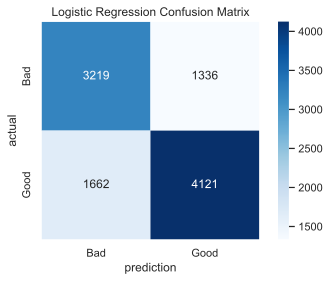

In [805]:
lm_confusion_test_base = confusion_matrix(y_test, lm.predict(X_test))
plt.figure(dpi=80)
sns.heatmap(lm_confusion_test_base, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Logistic Regression Confusion Matrix');

In [651]:
y_predict = lm.predict_proba(X_train)[:,1] > 0.7
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
#Precision went from 0.755 to 0.840

Tuned precision on train:  0.840


In [652]:
y_predict_val = lm.predict_proba(X_val)[:,1] > 0.7
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))

#Precision went from 0.752 to 0.840
#Recall went from 0.718 to 0.439

#precision: tuned is 0.840 and 0.840 for train and val respectively
#recall: tuned is 0.446 and 0.439 for train and val respectively

Tuned precision on validation:  0.840


In [653]:
y_predict_test = lm.predict_proba(X_test)[:,1] > 0.7
print("Tuned precision on test: {:6.3f}".format(precision_score(y_test, y_predict_test)))


Tuned precision on test:  0.848


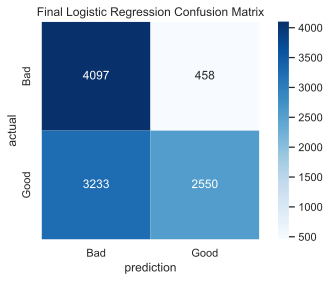

In [803]:
lm_confusion_test_tuned = confusion_matrix(y_test, lm.predict_proba(X_test)[:,1] > 0.7)
plt.figure(dpi=80)
sns.heatmap(lm_confusion_test_tuned, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Bad', 'Good'],
       yticklabels=['Bad', 'Good'])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Final Logistic Regression Confusion Matrix');

### Decision Tree - Test Set

In [654]:
y_predict = dt_grid_search.predict(X_train)
y_predict_val = dt_grid_search.predict(X_val)
y_predict_test = dt_grid_search.predict(X_test)
print("Tuned precision on train: {:6.3f}".format(precision_score(y_train, y_predict)))
print("Tuned precision on validation: {:6.3f}".format(precision_score(y_val, y_predict_val)))
print("Tuned precision on test: {:6.3f}".format(precision_score(y_test, y_predict_test)))

#train: 0.877 to 0.762
#validation: 0.720 to 0.759
#improvement

Tuned precision on train:  0.762
Tuned precision on validation:  0.759
Tuned precision on test:  0.759


### WordCloud

In [732]:
df_wine = df.copy()

In [756]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np

In [770]:
text = " ".join(review for review in df_wine.Description)

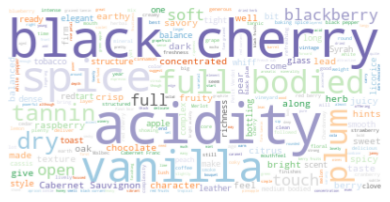

<Figure size 864x360 with 0 Axes>

In [801]:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", 
                  "flavors", "finish", "aroma", "aromas", 
                  "palate", "nose", "note", "blend",
                  "hint", "show", "notes", "rich", 
                  "ripe", "offer", "offers", "fruit",
                  "light", "fresh", 
                  "shows"])

wc = WordCloud(stopwords=stopwords, background_color="white", 
               colormap='tab20c',max_words=2000,
               max_font_size=60, random_state=42).generate(text)
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(12,5))
plt.savefig("Wine Word Cloud", bbox_inches = "tight");
plt.show()

### Baseline ROC Curve for LogReg

In [289]:
fpr, tpr, thresholds = roc_curve(y_train, lm.predict_proba(X_train)[:,1])

ROC AUC score =  0.7885681650960129


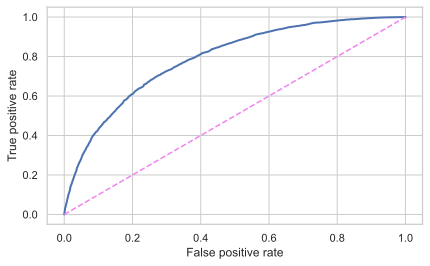

In [290]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate');
print("ROC AUC score = ", roc_auc_score(y_train, lm.predict_proba(X_train)[:,1]))
#ROC AUC measures how accurate your probabilites are across the board